In [12]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
from functools import partial

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    CropForegroundd,
    Orientationd,
    Spacingd,
    AsDiscrete,
)
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.inferers import sliding_window_inference

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load('best_spleen_metric_model.pth'))

<All keys matched successfully>

In [7]:
val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityRanged(
            keys=["img"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["img", "seg"], source_key="img"),
        Orientationd(keys=["img", "seg"], axcodes="RAS"),
        Spacingd(keys=["img", "seg"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [10]:
data_dir = "Task09_Spleen/"

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [{"img": image_name, "seg": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

val_dataset = CacheDataset(data=val_files, transform=val_transform, cache_rate=1.0, num_workers=os.cpu_count() // 2)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=os.cpu_count() // 2)

Loading dataset: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]


In [31]:
predictions = []
post_pred = AsDiscrete(argmax=True, to_onehot=2)
"""

with torch.no_grad():
    for batch_data in val_loader:
        img = batch_data["img"].to(device)
        prob = torch.sigmoid(model_inferer_test(img))

        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))

        outputs = sliding_window_inference(img, (160, 160, 160), 4, model)
        outputs = [post_pred(i) for i in decollate_batch(outputs)]

"""

model.eval()
with torch.no_grad():
    for idx, val_data in enumerate(val_loader):
        img = val_data["img"].to(device)
        seg = val_data["seg"].to(device)
        outputs = sliding_window_inference(img, (160, 160, 160), 4, model)
        outputs = torch.sigmoid(outputs).detach().cpu().numpy()
        outputs = (outputs < 0.5).astype(np.int8)
        predictions.append((outputs[0], seg[0].detach().cpu().numpy(), img[0].detach().cpu().numpy()))


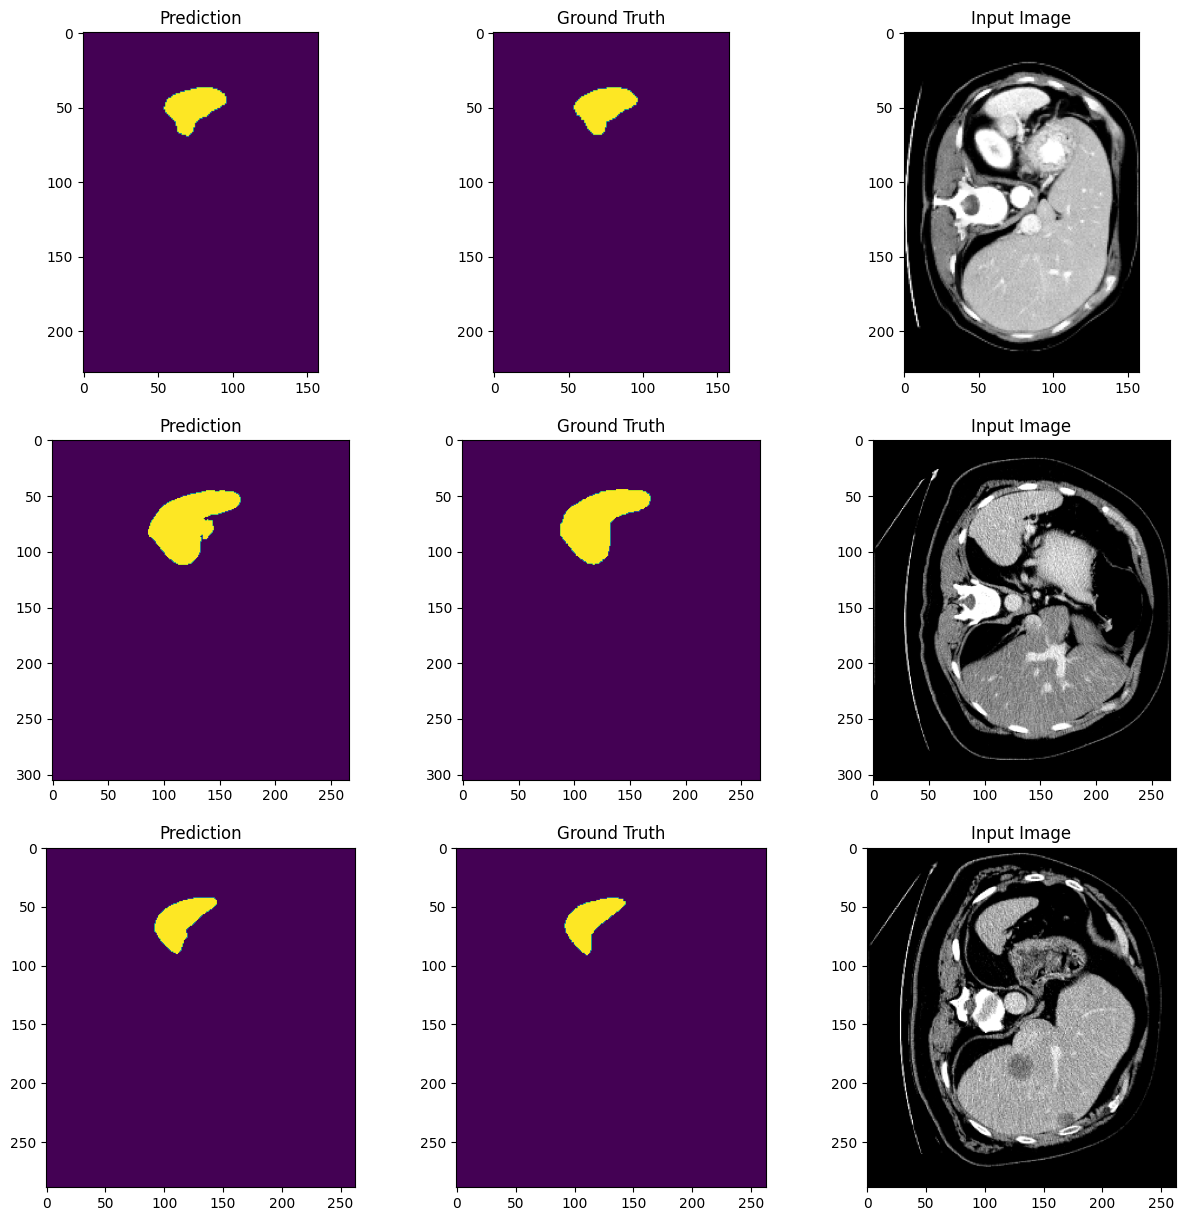

In [33]:
# plot the first three in predictions

slice = 80

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    ax[i, 0].imshow(predictions[i][0][0, :, :, slice])
    ax[i, 0].set_title("Prediction")
    ax[i, 1].imshow(predictions[i][1][0, :, :, slice])
    ax[i, 1].set_title("Ground Truth")
    ax[i, 2].imshow(predictions[i][2][0, :, :, slice], cmap="gray")
    ax[i, 2].set_title("Input Image")